In [1]:
from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Preprocess the data

In [2]:
# Transforms to perform on the dataset
# We will convert the image to a Tensor
# Then we will mean normalize the tensor
# Normalize to a mean on 0.5 with a std dev of 0.5
# One for each channel
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# We first grab the data and create a dataset and apply the above transforms to it
# Then we create a dataloader with a batch size of 32 and also shuffle the data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# We grab the test set and create a dataloader with the same mini batch size but we set shuffle to
# false for obvious reasons
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

### Let's look at the images

torch.Size([1, 28, 28])
[ ' 7 ' ,   ' 7 ' ,   ' 0 ' ,   ' 8 ' ,   ' 6 ' ,   ' 8 ' ,   ' 3 ' ,   ' 2 ' ,   ' 8 ' ,   ' 1 ' ,   ' 9 ' ,   ' 8 ' ,   ' 9 ' ,   ' 7 ' ,   ' 7 ' ,   ' 7 ' ,   ' 9 ' ,   ' 4 ' ,   ' 6 ' ,   ' 2 ' ,   ' 5 ' ,   ' 1 ' ,   ' 7 ' ,   ' 7 ' ,   ' 0 ' ,   ' 6 ' ,   ' 1 ' ,   ' 4 ' ,   ' 1 ' ,   ' 8 ' ,   ' 9 ' ,   ' 9 ' ]


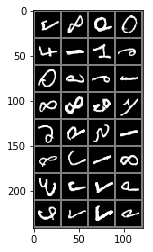

Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = sel

In [3]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg.transpose())

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images[0].size())

imgshow(torchvision.utils.make_grid(images))
array = [classes[labels[j]] for j in range(32)]

print(' '.join(f'{array}'))

## Let's build a Model for this problem

- We will first train a simple model with no Convolutions
- Next we will train a more complex model based on ResNet

We will use a series of fully connect layers of size 1024 neurons. Dropout with a probability of 0.5 will be used to reduce overfitting.

We will use ReLU activation for the hidden layers and Softmax for the final output layer

In [4]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.dropout = nn.Dropout(p=0.5)
        self.bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)
        self.ReLU = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return self.softmax(x)

simple_net = SimpleNet()
simple_net = simple_net.cuda()
print(simple_net)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=1024)
  (dropout): Dropout(p=0.5)
  (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear(in_features=1024, out_features=1024)
  (fc3): Linear(in_features=1024, out_features=10)
  (ReLU): ReLU(inplace)
  (softmax): Softmax()
)


### Let's create the loss function and optimizer
- We will use the CrossEntropy Loss function
- We will use SGD with Momentum

In [ ]:
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_net.parameters(), lr=learning_rate, momentum=0.9)
simple_net.train()

### Let's train the network

In [6]:
def train(num_epochs, trainloader, net, criterion, optimizer):
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
            if i % 500 == 499:
                print(f'[{epoch + 1} {i + 1}] Loss: {running_loss/500}')
                running_loss = 0.0

    print('Finished Training')

In [19]:
train(15, trainloader, simple_net, criterion, optimizer)

[1 500] Loss: 1.5457993295192718
[1 1000] Loss: 1.5385815272331238
[1 1500] Loss: 1.5384490354061127
[2 500] Loss: 1.537696879863739
[2 1000] Loss: 1.5380622193813325
[2 1500] Loss: 1.5378902728557586
[3 500] Loss: 1.538299946308136
[3 1000] Loss: 1.5366844041347503
[3 1500] Loss: 1.5345395228862762
[4 500] Loss: 1.5359351556301117
[4 1000] Loss: 1.537395118713379
[4 1500] Loss: 1.5345355017185212
[5 500] Loss: 1.5334057495594025
[5 1000] Loss: 1.5328377861976623
[5 1500] Loss: 1.5340110762119292
[6 500] Loss: 1.5342496185302734
[6 1000] Loss: 1.5317568633556367
[6 1500] Loss: 1.5329906957149506
[7 500] Loss: 1.532659892320633
[7 1000] Loss: 1.5347304439544678
[7 1500] Loss: 1.5336033535003661
[8 500] Loss: 1.5316065652370452
[8 1000] Loss: 1.53680650138855
[8 1500] Loss: 1.5331034498214722
[9 500] Loss: 1.5349918439388275
[9 1000] Loss: 1.5320035157203675
[9 1500] Loss: 1.531144495487213
[10 500] Loss: 1.5312389452457429
[10 1000] Loss: 1.5335959510803223
[10 1500] Loss: 1.53141406011

GroundTruth:  [ ' 7 ' ,   ' 2 ' ,   ' 1 ' ,   ' 0 ' ,   ' 4 ' ,   ' 1 ' ,   ' 4 ' ,   ' 9 ' ,   ' 5 ' ,   ' 9 ' ,   ' 0 ' ,   ' 6 ' ,   ' 9 ' ,   ' 0 ' ,   ' 1 ' ,   ' 5 ' ,   ' 9 ' ,   ' 7 ' ,   ' 3 ' ,   ' 4 ' ,   ' 9 ' ,   ' 6 ' ,   ' 6 ' ,   ' 5 ' ,   ' 4 ' ,   ' 0 ' ,   ' 7 ' ,   ' 4 ' ,   ' 0 ' ,   ' 1 ' ,   ' 3 ' ,   ' 1 ' ]


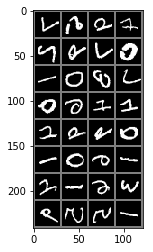

In [20]:
simple_net.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imgshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('{0}'.format([classes[labels[j]] for j in range(32)])))

In [21]:
outputs = simple_net(Variable(images).cuda())

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('{}'.format([classes[predicted[j]] for j in range(32)])))

Predicted:  [ ' 7 ' ,   ' 2 ' ,   ' 1 ' ,   ' 0 ' ,   ' 4 ' ,   ' 1 ' ,   ' 4 ' ,   ' 9 ' ,   ' 6 ' ,   ' 9 ' ,   ' 0 ' ,   ' 6 ' ,   ' 9 ' ,   ' 0 ' ,   ' 1 ' ,   ' 5 ' ,   ' 9 ' ,   ' 7 ' ,   ' 3 ' ,   ' 4 ' ,   ' 9 ' ,   ' 6 ' ,   ' 6 ' ,   ' 5 ' ,   ' 4 ' ,   ' 0 ' ,   ' 7 ' ,   ' 4 ' ,   ' 0 ' ,   ' 1 ' ,   ' 3 ' ,   ' 1 ' ]


In [24]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    outputs = simple_net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: {} %%'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 92.73 %%


## A better model

In [ ]:
class MNISTNet(nn.module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, )